In [39]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'Overshoot'
    author = 'Wang_Yue'
    
    # 策略参数
    mastop = 30
    lot = 100
    period = 72
    longperiod = 60
    mugap = 0.1
    
    # 策略变量
    maStop = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    Stoptracking = {} #记录量是否增长
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'mastop',
                 'period',
                 'longperiod',
                 'mugap',
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'Stoptracking',
               'transactionPrice',
               'maStop'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        if symbol not in self.Stoptracking.keys():
            self.Stoptracking[symbol] = 0.04
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.Stoptracking[symbol])
        longProfit = self.transactionPrice[symbol]*(1+5*self.Stoptracking[symbol])
        shortStop = self.transactionPrice[symbol]*(1+self.Stoptracking[symbol])
        shortProfit = self.transactionPrice[symbol]*(1-5*self.Stoptracking[symbol])
        if symbol not in self.maStop.keys():
            self.maStop[symbol] = ""
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)
            elif  (bar.close > longProfit or self.maStop[symbol]=="longstop"):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)
            elif (bar.close < shortProfit or self.maStop[symbol] == "shortstop"):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)

    #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "30m")
        
        if not am15.inited:
            return
        gap = (am15.close - am15.open)/am15.open
        mu = sum(np.abs(gap[-self.period:]))/self.period
        std = np.std(np.abs(gap[-self.period:]))
        current = gap[-1]
        longma = ta.EMA(am15.close,self.longperiod)
        angel = ta.LINEARREG_ANGLE(longma,5)
        Maarr = ta.EMA(am15.close,self.mastop)
        Ma5 = ta.EMA(am15.close,5)
        if self.posDict[symbol+'_LONG'] > 0:
            if Ma5[-2]>Maarr[-2] and Ma5[-1]<Maarr[-1]:
                self.maStop[symbol] = "longstop"
        elif self.posDict[symbol+'_SHORT'] > 0:
            if Ma5[-2]<Maarr[-2] and Ma5[-1]>Maarr[-1]:
                self.maStop[symbol] = "shortstop"
        #volmu = sum(am15.volume[-self.period:])/self.period
        #volstd = np.std(am15.volume[-self.period:])
        #volcur = am15.volume[-1]
        #engulfing = max(am15.close[-1],am15.open[-1])>max(am15.close[-2],am15.open[-2]) and min(am15.close[-1],am15.open[-1])<min(am15.close[-2],am15.open[-2])
        if current>0 and (current>(mu+4*std)) and angel[-1]>0 and (mu<self.mugap):
            # 做多信号
            if  (self.posDict[symbol+'_SHORT']==0)and(self.posDict[symbol+'_LONG']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
            self.Stoptracking[symbol] = np.abs(current)*0.4
        # 做空信号
        elif current<0 and (np.abs(current)>(mu+4*std)) and angel[-1]<0 and (mu<self.mugap):
            if (self.posDict[symbol+'_LONG']==0)and(self.posDict[symbol+'_SHORT']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
            self.Stoptracking[symbol] = np.abs(current)*0.4
        self.putEvent()
    
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


In [34]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

In [35]:
#parameterDict = {'symbolList':['BTCUSDT:binance']}
#runBacktesting(MultiFrameMaStrategy, parameterDict, '20180615 12:00', '20181130 12:00', 0.002, 5/10000)

In [36]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180615 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181130 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12fa19598>, <__main__.MultiFrameMaStrategy object at 0x12e80b668>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12fa19ae8>, <__main__.MultiFrameMaStrategy object at 0x12e80b668>)
2018-12-13 14:31:50.683722	开始回测
2018-12-13 14:31:50.683810	策略初始化
2018-12-13 14:31:50.686045	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:31:52.620001	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:31:52.623441	载入完成，数据量：12000
2018-12-13 14:31:52.623940	策略初始化完成
2018-12-13 14:31:52.624015	策略启动完成
2018-12-13 14:31:52.624112	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:31:52.650172	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:32:06.313402	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:32:06.393281	载入完成，数据量：240128
2018-12-13 14:32:06.394178

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

In [37]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('period', 24, 72, 24)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('longperiod', 40, 80, 20)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('mugap', 0.08, 0.12, 0.02)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-13 14:32:29.185194	------------------------------
2018-12-13 14:32:29.185494	setting: {'period': 24, 'longperiod': 40, 'mugap': 0.08, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12fa19ae8>, <__main__.MultiFrameMaStrategy object at 0x11bac9dd8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12fa19598>, <__main__.MultiFrameMaStrategy object at 0x11bac9dd8>)
2018-12-13 14:32:29.208109	开始回测
2018-12-13 14:32:29.208261	策略初始化
2018-12-13 14:32:29.210363	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:32:29.819960	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:32:29.825627	载入完成，数据量：12000
2018-12-13 14:32:29.826075	策略初始化完成
2018-12-13 14:32:29.826137	策略启动完成
2018-12-13 14:32:29.826393	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:32:29.851442

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 983365	Progress: 2%    {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-25 22:30:00 {'BTCUSDT:binance_LON

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-25 22:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binan

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-25 22:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binan

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-25 22:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binan

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-25 22:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binan

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-25 22:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binan

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 984692	Progress: 2%    {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-20 09:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG'

2018-11-23 07:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-11-25 05:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-11-28 13:00:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-12-13 14:36:33.312120	数据回放结束ss: 100%    
2018-12-13 14:36:33.312420	计算按日统计结果
2018-12-13 14:36:33.452777	------------------------------
2018-12-13 14:36:33.452955	setting: {'period': 48, 'longperiod': 40, 'mugap': 0.1, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12f9c5ae8>, <__main__.MultiFrameMaStrategy object at 0x11f471cf8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12f9c5b70>, <__main__.MultiFrameMaStrategy object at 0x11f471cf8>)
2018-12-13 14:36:33.465780	开始回测
2018-12-13 14:

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-20 09:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_S

2018-11-28 13:00:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-12-13 14:37:07.407799	数据回放结束ss: 100%    
2018-12-13 14:37:07.407923	计算按日统计结果
2018-12-13 14:37:07.547412	------------------------------
2018-12-13 14:37:07.547593	setting: {'period': 48, 'longperiod': 60, 'mugap': 0.08, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12f9af158>, <__main__.MultiFrameMaStrategy object at 0x11c479d30>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12f9afc80>, <__main__.MultiFrameMaStrategy object at 0x11c479d30>)
2018-12-13 14:37:07.560610	开始回测
2018-12-13 14:37:07.560743	策略初始化
2018-12-13 14:37:07.562085	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:37:08.178642	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:37:08.182722	载入完成，数据量：

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:37:42.114312	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:37:42.118239	载入完成，数据量：12000
2018-12-13 14:37:42.118683	策略初始化完成
2018-12-13 14:37:42.118753	策略启动完成
2018-12-13 14:37:42.118964	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:37:42.144062	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:37:53.004624	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:37:53.072642	载入完成，数据量：240128
2018-12-13 14:37:53.073241	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:37:53.076769	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:37:53.283626	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:37:53.284846	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:37:53.309441	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:3

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:38:16.038142	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:38:16.042185	载入完成，数据量：12000
2018-12-13 14:38:16.042648	策略初始化完成
2018-12-13 14:38:16.042721	策略启动完成
2018-12-13 14:38:16.042966	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:38:16.067867	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:38:26.852440	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:38:26.918833	载入完成，数据量：240128
2018-12-13 14:38:26.919305	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:38:26.922223	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:38:27.293133	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:38:27.294387	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:38:27.318038	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:3

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:38:50.051368	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:38:50.055531	载入完成，数据量：12000
2018-12-13 14:38:50.055976	策略初始化完成
2018-12-13 14:38:50.056050	策略启动完成
2018-12-13 14:38:50.056260	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:38:50.091592	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:39:00.977591	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:39:01.045463	载入完成，数据量：240128
2018-12-13 14:39:01.045875	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:39:01.048650	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:39:01.428072	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:39:01.429299	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:39:01.453223	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:3

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00.137642	Progress: 2%     {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LO

2018-12-13 14:39:41.970763	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:39:42.052018	载入完成，数据量：240128
2018-12-13 14:39:42.052619	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:39:42.056505	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:39:42.305039	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:39:42.306273	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:39:42.335818	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:39:43.917838	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-13 14:39:43.925360	载入完成，数据量：25730
2018-12-13 14:39:43.928677	载入历史数据。数据范围:[20180617 12:01,20180617 12:30)
2018-12-13 14:39:43.933668	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:39:43.933754	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:40:08.569399	数据回放结束ss: 100%    
2018-12-13 14:40:08.569576	计算按日统计结果
2018-12-13 14:40:08.701931	------------------------------
2018-12-13 14:40:08.702104	setting: {'period': 72, 'longperiod': 40, 'mugap': 0.1, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12f9ce7b8>, <__main__.MultiFrameMaStrategy object at 0x11e34bcf8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12f9ce488>, <__main__.MultiFrameMaStrategy object at 0x11e34bcf8>)
2018-12-13 14:40:08.715651	开始回测
2018-12-13 14:40:08.715785	策略初始化
2018-12-13 14:40:08.717112	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:40:09.479372	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:40:09.483642	载入完成，数据量：12000
2018-12-13 14:40:09.484112	策略初始化完成
2018-12-13 14:40:09.484240	策略启动完成
2018-12-13 14:40:0

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:40:49.231322	数据回放结束ss: 100%    
2018-12-13 14:40:49.231472	计算按日统计结果
2018-12-13 14:40:49.390239	------------------------------
2018-12-13 14:40:49.390540	setting: {'period': 72, 'longperiod': 60, 'mugap': 0.08, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12f9cee18>, <__main__.MultiFrameMaStrategy object at 0x121915c50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12f9ce488>, <__main__.MultiFrameMaStrategy object at 0x121915c50>)
2018-12-13 14:40:49.403182	开始回测
2018-12-13 14:40:49.403328	策略初始化
2018-12-13 14:40:49.405314	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:40:50.216527	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:40:50.220686	载入完成，数据量：12000
2018-12-13 14:40:50.221705	策略初始化完成
2018-12-13 14:40:50.221817	策略启动完成
2018-12-13 14:40:

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:41:30.948786	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:41:30.952832	载入完成，数据量：12000
2018-12-13 14:41:30.953286	策略初始化完成
2018-12-13 14:41:30.953468	策略启动完成
2018-12-13 14:41:30.953562	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:41:30.979444	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:41:42.123654	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:41:42.193224	载入完成，数据量：240128
2018-12-13 14:41:42.193762	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:41:42.196461	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:41:42.420179	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:41:42.421380	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:41:42.446128	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:4

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00.374869	Progress: 2%     {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LO

2018-12-13 14:42:04.982517	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:42:04.986627	载入完成，数据量：12000
2018-12-13 14:42:04.987071	策略初始化完成
2018-12-13 14:42:04.987255	策略启动完成
2018-12-13 14:42:04.987349	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:42:05.013269	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:42:18.807236	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:42:18.886577	载入完成，数据量：240128
2018-12-13 14:42:18.887174	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:42:18.890641	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:42:19.132598	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:42:19.133800	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:42:19.161232	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:4

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

2018-12-13 14:42:56.306240	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:42:56.378195	载入完成，数据量：240128
2018-12-13 14:42:56.378826	当前回放数据:[20180615 12:00,20181130 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-13 14:42:56.382331	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-13 14:42:56.609771	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:42:56.611008	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-13 14:42:56.635623	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-13 14:42:58.068168	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-13 14:42:58.077248	载入完成，数据量：25730
2018-12-13 14:42:58.080531	载入历史数据。数据范围:[20180617 12:01,20180617 12:30)
2018-12-13 14:42:58.084993	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:42:58.085082	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

In [38]:
import pandas as pd

pd.DataFrame(resultList).sort_values(1,  ascending=False)

,0,1,2
0,"[{'period': 72, 'longperiod': 60, 'mugap': 0.0...",2.011787,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
1,"[{'period': 72, 'longperiod': 60, 'mugap': 0.1...",2.011787,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
2,"[{'period': 48, 'longperiod': 60, 'mugap': 0.0...",1.778877,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
3,"[{'period': 48, 'longperiod': 60, 'mugap': 0.1...",1.778877,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
4,"[{'period': 48, 'longperiod': 80, 'mugap': 0.0...",1.774070,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
5,"[{'period': 48, 'longperiod': 80, 'mugap': 0.1...",1.774070,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
6,"[{'period': 72, 'longperiod': 40, 'mugap': 0.0...",1.631729,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
7,"[{'period': 72, 'longperiod': 40, 'mugap': 0.1...",1.631729,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
9,"[{'period': 72, 'longperiod': 80, 'mugap': 0.1...",1.548619,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
8,"[{'period': 72, 'longperiod': 80, 'mugap': 0.0...",1.548619,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."


仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12f9c5f28>, <__main__.MultiFrameMaStrategy object at 0x12e80b3c8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12fa0fa60>, <__main__.MultiFrameMaStrategy object at 0x12e80b3c8>)
2018-12-13 14:49:12.484700	开始回测
2018-12-13 14:49:12.484767	策略初始化
2018-12-13 14:49:12.487278	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:49:13.119405	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:49:13.122945	载入完成，数据量：12000
2018-12-13 14:49:13.123392	策略初始化完成
2018-12-13 14:49:13.123450	策略启动完成
2018-12-13 14:49:13.123667	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:49:13.153098	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:49:24.835571	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:49:24.911794	载入完成，数据量：240128
2018-12-13 14:49:24.912246

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

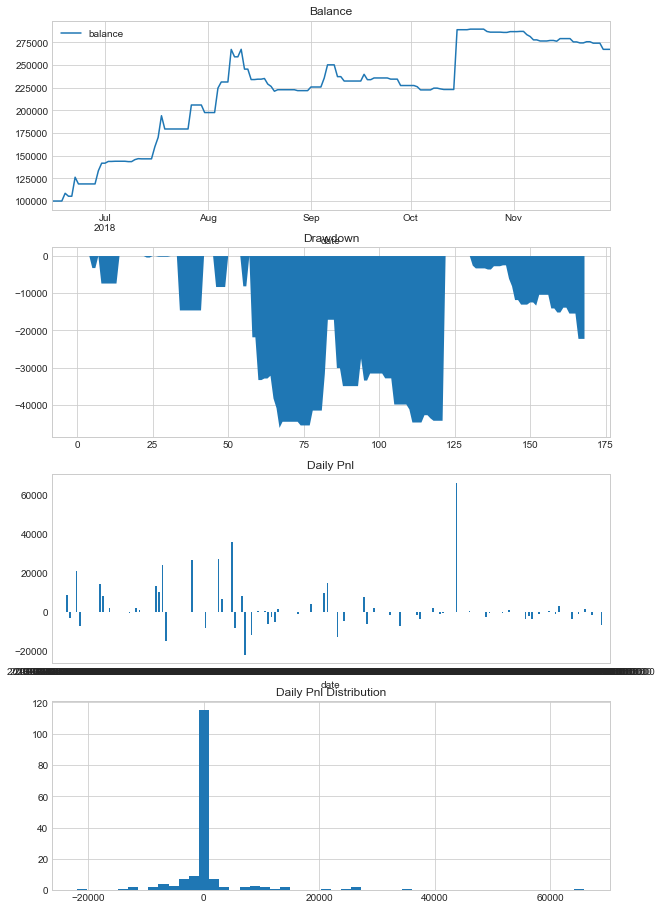

2018-12-13 14:49:54.578528	计算回测结果
2018-12-13 14:49:54.995077	------------------------------
2018-12-13 14:49:54.995284	第一笔交易：	2018-06-20 06:30:00
2018-12-13 14:49:54.995342	最后一笔交易：	2018-11-28 16:37:00
2018-12-13 14:49:54.995397	总交易次数：	72
2018-12-13 14:49:54.995457	总盈亏：	167,308.92
2018-12-13 14:49:54.995641	最大回撤: 	-46,625.02
2018-12-13 14:49:54.995695	平均每笔盈利：	2,323.74
2018-12-13 14:49:54.995776	平均每笔滑点：	0.4
2018-12-13 14:49:54.995939	平均每笔佣金：	634.14
2018-12-13 14:49:54.995996	胜率		40.28%
2018-12-13 14:49:54.996052	盈利交易平均值	11,854.08
2018-12-13 14:49:54.996128	亏损交易平均值	-4,103.71
2018-12-13 14:49:54.996301	盈亏比：	2.89


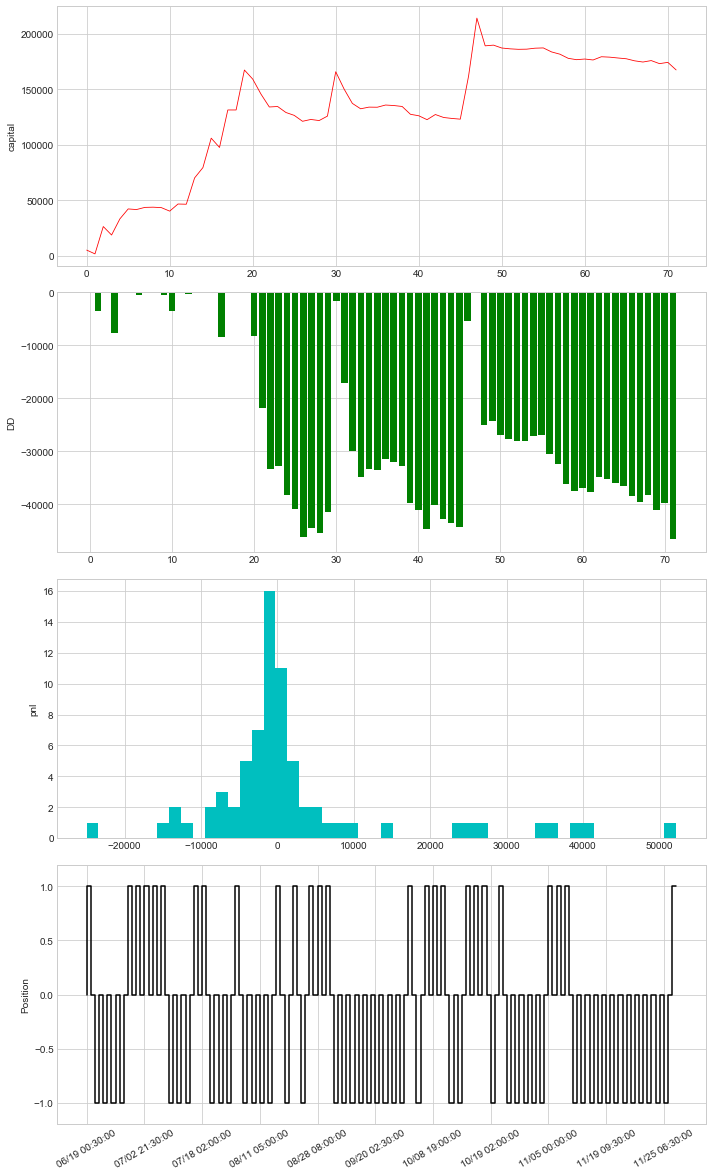

2018-12-13 14:49:56.213198	计算按日统计结果


(                netPnl  slippage  commission   turnover  tradeCount  \
 date                                                                  
 2018-06-15      0.0000       0.0      0.0000        0.0           0   
 2018-06-16      0.0000       0.0      0.0000        0.0           0   
 2018-06-17      0.0000       0.0      0.0000        0.0           0   
 2018-06-18      0.0000       0.0      0.0000        0.0           0   
 2018-06-19   8532.2805       0.2    332.5195   665039.0           1   
 2018-06-20  -3241.6990       0.2    335.4990   670998.0           1   
 2018-06-21      0.0000       0.0      0.0000        0.0           0   
 2018-06-22  20961.5275       1.0   1610.4725  3220945.0           5   
 2018-06-23  -7405.2470       0.2    311.0470   622094.0           1   
 2018-06-24      0.0000       0.0      0.0000        0.0           0   
 2018-06-25      0.0000       0.0      0.0000        0.0           0   
 2018-06-26      0.0000       0.0      0.0000        0.0        

In [40]:
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180615 12:00', '20181130 12:00', 0.002, 5/10000)